# Boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
series = pd.read_table('series.csv', sep=',')
series.head()

,value
0,52.483570
1,49.352750
2,53.314735
3,57.711823
4,48.934444


In [3]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 1 columns):
value    1461 non-null float64
dtypes: float64(1)
memory usage: 11.5 KB


In [4]:
series.describe()

,value
count,1461.000000
mean,53.954441
std,25.399524
min,-21.603771
25%,33.992973
50%,53.336246
75%,73.622010
max,122.307720


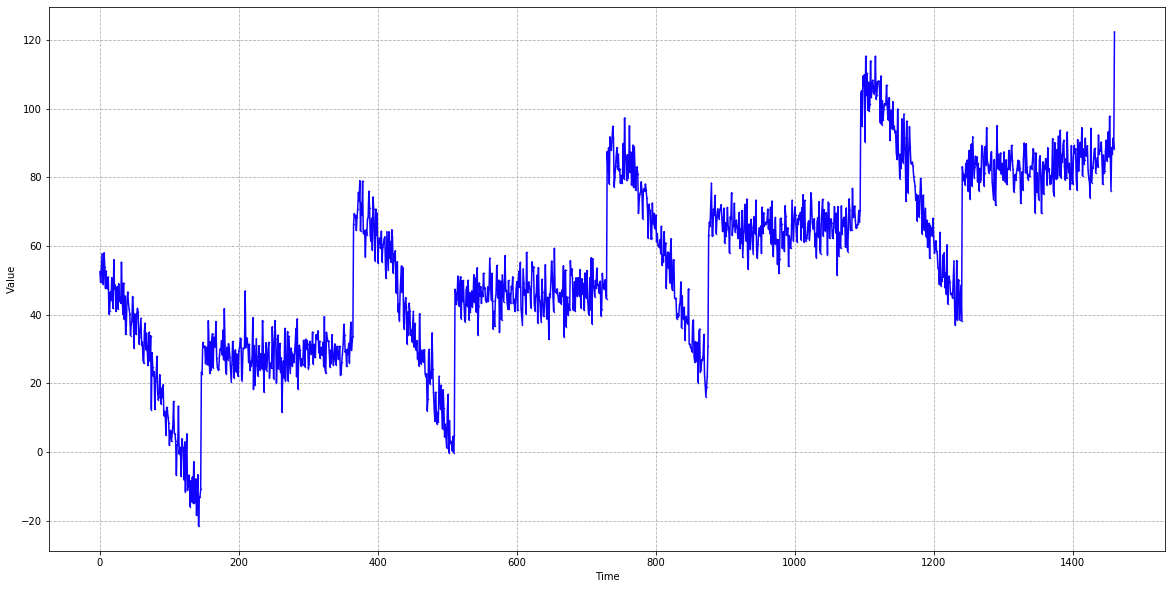

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.plot(series.values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

In [6]:
split_time = 1000

t_train = np.array(range(0,split_time+1))
x_train = series.loc[:split_time,['value']].astype('float32').values

t_test = np.array(range(split_time+1,series.shape[0]+1))
x_test = series.loc[split_time:,['value']].astype('float32').values

In [7]:
window_size = 10

X_train = []
Y_train = []
for i in range(x_train.shape[0]-window_size):
    X_train.append(x_train[i:i+window_size,0])
    Y_train.append(x_train[[i+window_size],0])
X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')

X_test = []
Y_test = []
for i in range(x_test.shape[0]-window_size):
    X_test.append(x_test[i:i+window_size,0])
    Y_test.append(x_test[[i+window_size],0])
X_test = np.array(X_test, dtype='float32')
Y_test = np.array(Y_test, dtype='float32')

In [8]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.maximum(0.,u)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        return tf.transpose(z)

In [9]:
class LossFunction():
    
    def __init__(self, model):
        self.model = model

    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.square(y_true-y_pred))

In [10]:
class MetricFunction():
                    
    def __init__(self, model):
        self.model = model
        
    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(y_true-y_pred))

In [11]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [12]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [13]:
class NN():
    
    def __init__(self, dims):
        self.dims = dims
        self.build()
    
    def build(self):
        self.layers = []
        self.layers.append(Layer1(model=self, input_dim=self.dims[0], output_dim=self.dims[0]))
        for i in range(len(self.dims)-2):
            self.layers.append(Layer2(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1]))
        self.layers.append(Layer3(model=self, input_dim=self.dims[-2], output_dim=self.dims[-1]))
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        y = inputs
        for layer in self.layers:
            y = layer(y)
        return y 
        
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=100, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=200, error=0.001)]
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [14]:
nn = NN(dims=[X_train.shape[1], 32, Y_train.shape[1]])

nn.fit(X_train, Y_train)

Train on 991 samples
Epochs 1/1000 - Loss: 2255.315673828125 - Metric: 43.14375686645508
----- 0.028s -----
Epochs 2/1000 - Loss: 2246.80859375 - Metric: 43.0605583190918
----- 0.008s -----
Epochs 3/1000 - Loss: 2235.53369140625 - Metric: 42.947967529296875
----- 0.009s -----
Epochs 4/1000 - Loss: 2219.633056640625 - Metric: 42.788570404052734
----- 0.008s -----
Epochs 5/1000 - Loss: 2198.52685546875 - Metric: 42.57621383666992
----- 0.01s -----
Epochs 6/1000 - Loss: 2171.70458984375 - Metric: 42.3056755065918
----- 0.008s -----
Epochs 7/1000 - Loss: 2138.75048828125 - Metric: 41.9741096496582
----- 0.007s -----
Epochs 8/1000 - Loss: 2099.46630859375 - Metric: 41.57986068725586
----- 0.007s -----
Epochs 9/1000 - Loss: 2053.83837890625 - Metric: 41.120208740234375
----- 0.011s -----
Epochs 10/1000 - Loss: 2002.128662109375 - Metric: 40.598968505859375
----- 0.016s -----
Epochs 11/1000 - Loss: 1944.868408203125 - Metric: 40.00802230834961
----- 0.014s -----
Epochs 12/1000 - Loss: 1882.86

----- 0.01s -----
Epochs 94/1000 - Loss: 82.19941711425781 - Metric: 7.035318851470947
----- 0.01s -----
Epochs 95/1000 - Loss: 79.82369232177734 - Metric: 6.922135353088379
----- 0.009s -----
Epochs 96/1000 - Loss: 77.56045532226562 - Metric: 6.816309452056885
----- 0.007s -----
Epochs 97/1000 - Loss: 75.40660095214844 - Metric: 6.715616226196289
----- 0.008s -----
Epochs 98/1000 - Loss: 73.36369323730469 - Metric: 6.618902206420898
----- 0.008s -----
Epochs 99/1000 - Loss: 71.42862701416016 - Metric: 6.525538921356201
----- 0.008s -----
Epochs 100/1000 - Loss: 69.5912857055664 - Metric: 6.432694435119629
----- 0.007s -----
Epochs 101/1000 - Loss: 67.84439849853516 - Metric: 6.339242935180664
----- 0.007s -----
Epochs 102/1000 - Loss: 66.18685150146484 - Metric: 6.247978687286377
----- 0.009s -----
Epochs 103/1000 - Loss: 64.61897277832031 - Metric: 6.1620097160339355
----- 0.008s -----
Epochs 104/1000 - Loss: 63.135807037353516 - Metric: 6.080779552459717
----- 0.007s -----
Epochs 10

Epochs 186/1000 - Loss: 42.516448974609375 - Metric: 4.8813395500183105
----- 0.009s -----
Epochs 187/1000 - Loss: 42.51005172729492 - Metric: 4.880853176116943
----- 0.008s -----
Epochs 188/1000 - Loss: 42.5036735534668 - Metric: 4.880364894866943
----- 0.008s -----
Epochs 189/1000 - Loss: 42.4973258972168 - Metric: 4.879894256591797
----- 0.007s -----
Epochs 190/1000 - Loss: 42.49102020263672 - Metric: 4.879444599151611
----- 0.008s -----
Epochs 191/1000 - Loss: 42.48474884033203 - Metric: 4.8790082931518555
----- 0.008s -----
Epochs 192/1000 - Loss: 42.47850036621094 - Metric: 4.878568649291992
----- 0.007s -----
Epochs 193/1000 - Loss: 42.4722900390625 - Metric: 4.87811279296875
----- 0.007s -----
Epochs 194/1000 - Loss: 42.46610641479492 - Metric: 4.877640247344971
----- 0.008s -----
Epochs 195/1000 - Loss: 42.459964752197266 - Metric: 4.8771586418151855
----- 0.008s -----
Epochs 196/1000 - Loss: 42.45384979248047 - Metric: 4.87667989730835
----- 0.009s -----
Epochs 197/1000 - Los

Epochs 278/1000 - Loss: 42.062110900878906 - Metric: 4.846107006072998
----- 0.009s -----
Epochs 279/1000 - Loss: 42.05854415893555 - Metric: 4.8458476066589355
----- 0.008s -----
Epochs 280/1000 - Loss: 42.05500030517578 - Metric: 4.845586776733398
----- 0.008s -----
Epochs 281/1000 - Loss: 42.051475524902344 - Metric: 4.845328330993652
----- 0.008s -----
Epochs 282/1000 - Loss: 42.0479621887207 - Metric: 4.845068454742432
----- 0.008s -----
Epochs 283/1000 - Loss: 42.04447937011719 - Metric: 4.844812393188477
----- 0.009s -----
Epochs 284/1000 - Loss: 42.04102325439453 - Metric: 4.844554901123047
----- 0.012s -----
Epochs 285/1000 - Loss: 42.03757095336914 - Metric: 4.844298362731934
----- 0.008s -----
Epochs 286/1000 - Loss: 42.03415298461914 - Metric: 4.844043731689453
----- 0.009s -----
Epochs 287/1000 - Loss: 42.03074264526367 - Metric: 4.8437886238098145
----- 0.009s -----
Epochs 288/1000 - Loss: 42.0273551940918 - Metric: 4.843535900115967
----- 0.007s -----
Epochs 289/1000 - L

Epochs 370/1000 - Loss: 41.794677734375 - Metric: 4.826894760131836
----- 0.009s -----
Epochs 371/1000 - Loss: 41.79222869873047 - Metric: 4.826712608337402
----- 0.009s -----
Epochs 372/1000 - Loss: 41.78977584838867 - Metric: 4.826531887054443
----- 0.007s -----
Epochs 373/1000 - Loss: 41.787330627441406 - Metric: 4.826352119445801
----- 0.007s -----
Epochs 374/1000 - Loss: 41.78489303588867 - Metric: 4.826169013977051
----- 0.007s -----
Epochs 375/1000 - Loss: 41.78243637084961 - Metric: 4.825988292694092
----- 0.007s -----
Epochs 376/1000 - Loss: 41.78001022338867 - Metric: 4.8258056640625
----- 0.006s -----
Epochs 377/1000 - Loss: 41.777584075927734 - Metric: 4.825624465942383
----- 0.006s -----
Epochs 378/1000 - Loss: 41.77516174316406 - Metric: 4.825441360473633
----- 0.006s -----
Epochs 379/1000 - Loss: 41.77272415161133 - Metric: 4.825255870819092
----- 0.006s -----
Epochs 380/1000 - Loss: 41.77027893066406 - Metric: 4.825070858001709
----- 0.007s -----
Epochs 381/1000 - Loss:

Epochs 462/1000 - Loss: 41.616878509521484 - Metric: 4.813114643096924
----- 0.007s -----
Epochs 463/1000 - Loss: 41.615543365478516 - Metric: 4.813017845153809
----- 0.007s -----
Epochs 464/1000 - Loss: 41.61420822143555 - Metric: 4.812920570373535
----- 0.006s -----
Epochs 465/1000 - Loss: 41.61288833618164 - Metric: 4.812824249267578
----- 0.007s -----
Epochs 466/1000 - Loss: 41.611568450927734 - Metric: 4.8127288818359375
----- 0.007s -----
Epochs 467/1000 - Loss: 41.61024856567383 - Metric: 4.812634468078613
----- 0.008s -----
Epochs 468/1000 - Loss: 41.608943939208984 - Metric: 4.812541961669922
----- 0.006s -----
Epochs 469/1000 - Loss: 41.60763931274414 - Metric: 4.8124494552612305
----- 0.006s -----
Epochs 470/1000 - Loss: 41.6063346862793 - Metric: 4.812356948852539
----- 0.007s -----
Epochs 471/1000 - Loss: 41.605037689208984 - Metric: 4.8122663497924805
----- 0.006s -----
Epochs 472/1000 - Loss: 41.60374450683594 - Metric: 4.812175273895264
----- 0.006s -----
Epochs 473/100

Epochs 554/1000 - Loss: 41.50995635986328 - Metric: 4.805456161499023
----- 0.008s -----
Epochs 555/1000 - Loss: 41.50893020629883 - Metric: 4.805384635925293
----- 0.007s -----
Epochs 556/1000 - Loss: 41.50791549682617 - Metric: 4.805312633514404
----- 0.006s -----
Epochs 557/1000 - Loss: 41.50688934326172 - Metric: 4.805241584777832
----- 0.007s -----
Epochs 558/1000 - Loss: 41.50587463378906 - Metric: 4.805171012878418
----- 0.007s -----
Epochs 559/1000 - Loss: 41.50486373901367 - Metric: 4.805099964141846
----- 0.007s -----
Epochs 560/1000 - Loss: 41.503841400146484 - Metric: 4.805028915405273
----- 0.007s -----
Epochs 561/1000 - Loss: 41.502838134765625 - Metric: 4.804957866668701
----- 0.008s -----
Epochs 562/1000 - Loss: 41.501827239990234 - Metric: 4.80488920211792
----- 0.008s -----
Epochs 563/1000 - Loss: 41.50082015991211 - Metric: 4.804819583892822
----- 0.008s -----
Epochs 564/1000 - Loss: 41.49982452392578 - Metric: 4.804749965667725
----- 0.007s -----
Epochs 565/1000 - L

Epochs 646/1000 - Loss: 41.424198150634766 - Metric: 4.799683570861816
----- 0.008s -----
Epochs 647/1000 - Loss: 41.423343658447266 - Metric: 4.799628257751465
----- 0.007s -----
Epochs 648/1000 - Loss: 41.42249298095703 - Metric: 4.799571990966797
----- 0.006s -----
Epochs 649/1000 - Loss: 41.4216423034668 - Metric: 4.7995171546936035
----- 0.006s -----
Epochs 650/1000 - Loss: 41.42079162597656 - Metric: 4.799461364746094
----- 0.006s -----
Epochs 651/1000 - Loss: 41.419944763183594 - Metric: 4.799405097961426
----- 0.007s -----
Epochs 652/1000 - Loss: 41.41910171508789 - Metric: 4.799348831176758
----- 0.007s -----
Epochs 653/1000 - Loss: 41.41824722290039 - Metric: 4.799294471740723
----- 0.006s -----
Epochs 654/1000 - Loss: 41.41740417480469 - Metric: 4.7992377281188965
----- 0.007s -----
Epochs 655/1000 - Loss: 41.41655731201172 - Metric: 4.799183368682861
----- 0.009s -----
Epochs 656/1000 - Loss: 41.415714263916016 - Metric: 4.79912805557251
----- 0.011s -----
Epochs 657/1000 -

Epochs 738/1000 - Loss: 41.35116958618164 - Metric: 4.794950008392334
----- 0.007s -----
Epochs 739/1000 - Loss: 41.35042953491211 - Metric: 4.794905185699463
----- 0.007s -----
Epochs 740/1000 - Loss: 41.34969711303711 - Metric: 4.794860363006592
----- 0.007s -----
Epochs 741/1000 - Loss: 41.34896469116211 - Metric: 4.794813632965088
----- 0.014s -----
Epochs 742/1000 - Loss: 41.34823226928711 - Metric: 4.794769287109375
----- 0.011s -----
Epochs 743/1000 - Loss: 41.347511291503906 - Metric: 4.794723987579346
----- 0.008s -----
Epochs 744/1000 - Loss: 41.34678268432617 - Metric: 4.794679641723633
----- 0.008s -----
Epochs 745/1000 - Loss: 41.34605407714844 - Metric: 4.794634819030762
----- 0.007s -----
Epochs 746/1000 - Loss: 41.345333099365234 - Metric: 4.794588088989258
----- 0.007s -----
Epochs 747/1000 - Loss: 41.344608306884766 - Metric: 4.794543266296387
----- 0.009s -----
Epochs 748/1000 - Loss: 41.3438835144043 - Metric: 4.794499397277832
----- 0.009s -----
Epochs 749/1000 - L

Epochs 830/1000 - Loss: 41.288387298583984 - Metric: 4.791383266448975
----- 0.006s -----
Epochs 831/1000 - Loss: 41.28776168823242 - Metric: 4.791350364685059
----- 0.006s -----
Epochs 832/1000 - Loss: 41.28712844848633 - Metric: 4.791316509246826
----- 0.007s -----
Epochs 833/1000 - Loss: 41.2864990234375 - Metric: 4.791281700134277
----- 0.006s -----
Epochs 834/1000 - Loss: 41.285865783691406 - Metric: 4.791248321533203
----- 0.007s -----
Epochs 835/1000 - Loss: 41.28523635864258 - Metric: 4.791214466094971
----- 0.007s -----
Epochs 836/1000 - Loss: 41.28459930419922 - Metric: 4.791180610656738
----- 0.007s -----
Epochs 837/1000 - Loss: 41.28396987915039 - Metric: 4.791146755218506
----- 0.006s -----
Epochs 838/1000 - Loss: 41.283348083496094 - Metric: 4.791112422943115
----- 0.007s -----
Epochs 839/1000 - Loss: 41.28270721435547 - Metric: 4.791077613830566
----- 0.006s -----
Epochs 840/1000 - Loss: 41.28207778930664 - Metric: 4.791044235229492
----- 0.006s -----
Epochs 841/1000 - L

----- 0.007s -----
Epochs 922/1000 - Loss: 41.24179458618164 - Metric: 4.788702487945557
----- 0.007s -----
Epochs 923/1000 - Loss: 41.24136734008789 - Metric: 4.788679599761963
----- 0.007s -----
Epochs 924/1000 - Loss: 41.24094772338867 - Metric: 4.788657188415527
----- 0.006s -----
Epochs 925/1000 - Loss: 41.24052429199219 - Metric: 4.788634300231934
----- 0.007s -----
Epochs 926/1000 - Loss: 41.24009323120117 - Metric: 4.788611888885498
----- 0.008s -----
Epochs 927/1000 - Loss: 41.23968505859375 - Metric: 4.788589000701904
----- 0.007s -----
Epochs 928/1000 - Loss: 41.239253997802734 - Metric: 4.788567066192627
----- 0.007s -----
Epochs 929/1000 - Loss: 41.23883819580078 - Metric: 4.78854513168335
----- 0.007s -----
Epochs 930/1000 - Loss: 41.23841857910156 - Metric: 4.7885236740112305
----- 0.008s -----
Epochs 931/1000 - Loss: 41.23799514770508 - Metric: 4.788501262664795
----- 0.007s -----
Epochs 932/1000 - Loss: 41.237579345703125 - Metric: 4.788479328155518
----- 0.01s -----
E

In [15]:
nn.evaluate(X_test, Y_test)

Loss: 45.29833984375 - Metric: 4.938704967498779


[45.29834, 4.938705]

In [16]:
class Boosting():
    
    def __init__(self, pack_size, shrinkage, model):
        self.pack_size = pack_size
        self.shrinkage = shrinkage
        self.model = model
        self.build()
    
    def build(self):
        self.pack = [] 
        for i in range(self.pack_size):
            m = self.model.__class__(dims=self.model.dims)
            self.pack.append(m)
                    
    def __call__(self, inputs):
        outputs = []
        for i in range(self.pack_size):
            outputs.append(self.pack[i](inputs))
        z = tf.concat(outputs, axis=1)
        y = self.shrinkage*tf.math.reduce_sum(z, axis=1, keepdims=True)
        return y
    
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = self.model.loss.__class__(model=self)
        self.metric = self.model.metric.__class__(model=self)
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=False):
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)
        tf.print('Boosting with {} models'.format(self.pack_size))
        R = (1/self.shrinkage)*Y
        for i in range(self.pack_size):
            start_time = tf.timestamp()
            tf.print('Training model {}/{}'.format(i+1, self.pack_size))
            self.pack[i].fit(X, R, epochs=epochs, learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, verbose=verbose)
            R = R - self.pack[i].predict(X)
            now = tf.timestamp()
            time = now - start_time
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
          
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [17]:
boosting = Boosting(pack_size=10, shrinkage=0.01, model=nn)

boosting.fit(X_train, Y_train)

Boosting with 10 models
Training model 1/10
----- 6.216s -----
Training model 2/10
----- 6.257s -----
Training model 3/10
----- 6.362s -----
Training model 4/10
----- 6.495s -----
Training model 5/10
----- 7.863s -----
Training model 6/10
----- 6.441s -----
Training model 7/10
----- 6.396s -----
Training model 8/10
----- 6.235s -----
Training model 9/10
----- 6.155s -----
Training model 10/10
----- 6.17s -----
Loss: 29.215652465820312 - Metric: 3.9157683849334717


In [18]:
boosting.evaluate(X_test, Y_test)

Loss: 41.641021728515625 - Metric: 4.8201680183410645


[41.64102, 4.820168]